# Time series generator for tensorseason

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from functools import reduce

In [2]:
def generate_trend(T, changepoint_probability=.0005, slope_std = .01):
    cp = np.random.binomial(n=1, p=changepoint_probability, size=T-2)
    cps = [0] + list(np.arange(T-2)[cp.astype(bool)]) + [T-1]
    slopes = np.random.randn(len(cps)-1) * slope_std
    t_t = np.zeros(T)
    for i in range(len(cps)-1):
        slope = slopes[i]
        no_days = cps[i+1] - cps[i] + 1
        t_t[cps[i]:cps[i+1]+1] = np.linspace(t_t[cps[i]], t_t[cps[i]] + slope * no_days, no_days)
    return t_t

def generate_sinusoid_seasonality(T, seasons, no_seasonality_components):
    s_t = np.zeros(T)
    seasons_prod = [np.prod(seasons[:i+1]) for i in range(len(seasons))]
    amplitudes = np.random.standard_t(4, size=(len(seasons_prod), no_seasonality_components, 2))
    for si, P in enumerate(seasons_prod):
        for n_1 in range(0, no_seasonality_components):
            a_n = amplitudes[si, n_1, 0]
            b_n = amplitudes[si, n_1, 1]
            s_t += a_n * np.exp(np.sin((2 * np.pi * (n_1+1) * np.arange(T))/P))
            s_t += b_n * np.exp(np.cos((2 * np.pi * (n_1+1) * np.arange(T))/P))
    return s_t

def generate_cp_seasonality(T, seasons, no_seasonality_components, nonnegative):
    mult = 1 if nonnegative else -1
    s_t = np.zeros(T)
    s_t_block = np.zeros(np.prod(seasons))
    for n in range(0, no_seasonality_components):
        comp_vectors = [np.random.poisson(.5, size=seasons[i]) * np.random.choice([mult, 1], size=seasons[i]) for i in range(len(seasons))]
        s_t_block += reduce(np.outer, comp_vectors).ravel()
    s_t = np.tile(s_t_block, len(s_t)//len(s_t_block)) # assumes total T is a multiple of whatever
    return s_t

def scale_s_t(s_t, t_t, seasonality_snr):
    snr_hat = np.mean(s_t ** 2) / np.mean(t_t ** 2)
    coef = np.sqrt(snr_hat / seasonality_snr)
    return s_t * (1/coef)

def generate_seasonality(seasons, seasonality_type, t_t, seasonality_snr, no_seasonality_components):
    T = len(t_t)
    s_t = np.zeros(T)
    no_seasonality_components
    if seasonality_type == "sinusoid":
        s_t = generate_sinusoid_seasonality(T, seasons, no_seasonality_components)
    elif seasonality_type == "cp":
        s_t = generate_cp_seasonality(T, seasons, no_seasonality_components, nonnegative=False)
    elif seasonality_type == "nonnegative_cp":
        s_t = generate_cp_seasonality(T, seasons, no_seasonality_components, nonnegative=True)
    else:
        raise ValueError("Seasonality type {} is not implemented".format(seasonality_type))
    s_t = scale_s_t(s_t, t_t, seasonality_snr)
    return s_t

def generate_noise(t_t, s_t, noise_snr):
    T = len(t_t)
    n_t = np.zeros(T)
    signal_t = t_t + s_t
    n_hat = np.random.randn(T)
    snr_hat = np.mean(signal_t ** 2) / np.mean(n_hat ** 2)
    noise_coef = np.sqrt(snr_hat / noise_snr)
    n_t = n_hat * noise_coef
    return n_t


def plot_ts(x_t, t_t, s_t, n_t):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fig, axes = plt.subplots(4, 1,sharex=True, sharey=True, figsize=(15,10))
        pd.Series(x_t).plot(ax=axes[0])
        pd.Series(t_t).plot(ax=axes[1])
        pd.Series(s_t).plot(ax=axes[2])
        pd.Series(n_t).plot(ax=axes[3])
        axes[3].set_xlabel("Time")
        fig.tight_layout()
        fig.suptitle(r"Seasonality/Trend SNR = {}, Signal/Noise SNR = {}".format(seasonality_snr, noise_snr))

def generate_ts(T, seasons, seasonality_type, seasonality_snr, noise_snr, no_seasonality_components=5, plot=True):
    assert T % np.prod(seasons) == 0
    t_t = generate_trend(T)
    s_t = generate_seasonality(seasons, seasonality_type, t_t, seasonality_snr, no_seasonality_components)
    n_t = generate_noise(t_t, s_t, noise_snr)
    x_t = t_t + s_t + n_t
    if plot:
        plot_ts(x_t, t_t, s_t, n_t)
    return x_t, t_t, s_t, n_t

## API

In [ ]:
seasons = [24, 7]
T = np.prod(seasons)*52
seasonality_type = "cp"
seasonality_snr = 1.
noise_snr = 10.

# default parameters: no_seasonality_components=5, plot=True
x_t, t_t, s_t, n_t = generate_ts(T=T, seasons=seasons, seasonality_type=seasonality_type, 
                                 seasonality_snr=seasonality_snr, noise_snr=noise_snr)

## Examples: Playing with SNRs

In [46]:
seasons = [24, 7]
T = np.prod(seasons)*52
seasonality_type = "cp"

### Strong seasonality + weak trend + noise

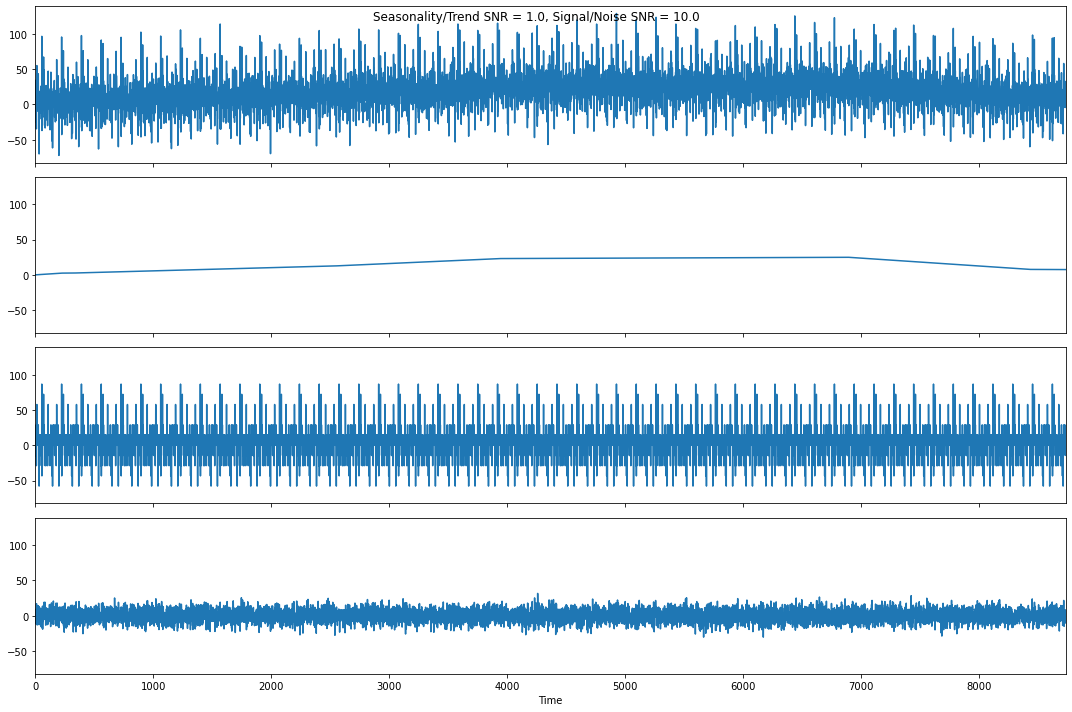

In [48]:
seasonality_snr = 1.
noise_snr = 10.
x_t, t_t, s_t, n_t = generate_ts(T=T, seasons=seasons, seasonality_type=seasonality_type, 
                                 seasonality_snr=seasonality_snr, noise_snr=noise_snr)

### Stronger trend + noise

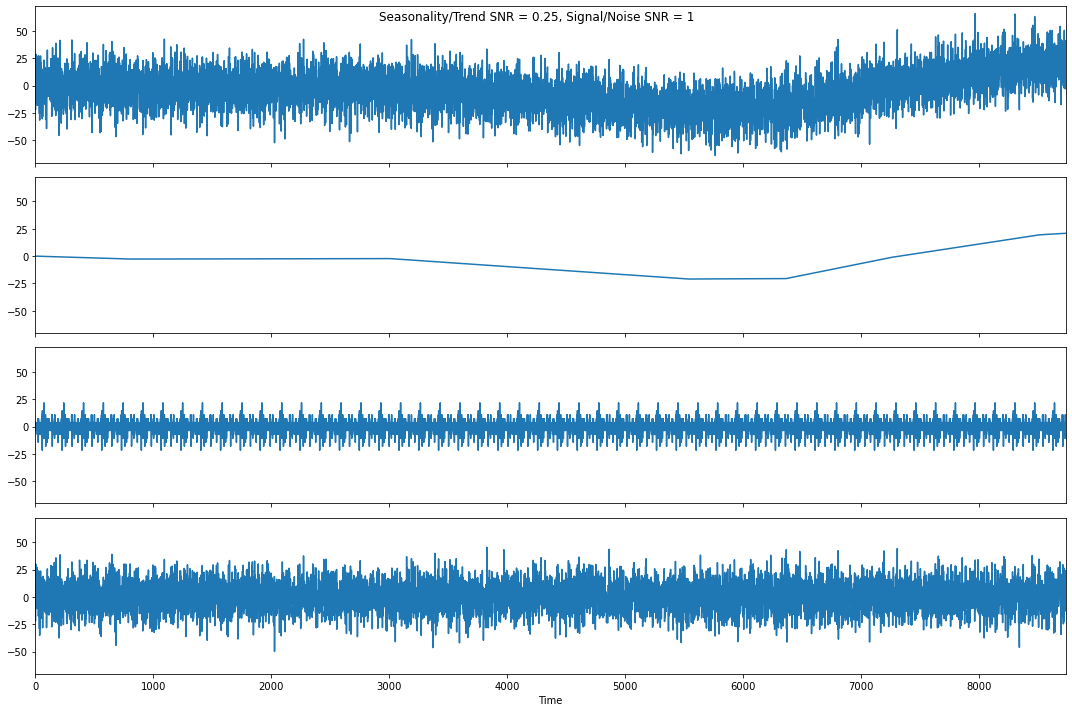

In [47]:
seasonality_snr = .25
noise_snr = 1
x_t, t_t, s_t, n_t = generate_ts(T=T, seasons=seasons, seasonality_type=seasonality_type, 
                                 seasonality_snr=seasonality_snr, noise_snr=noise_snr)

## Examples: Different seasonality types

In [ ]:
seasons = [24, 7]
T = np.prod(seasons)*52
seasonality_snr = 1.
noise_snr = 10.

### Sinusoid

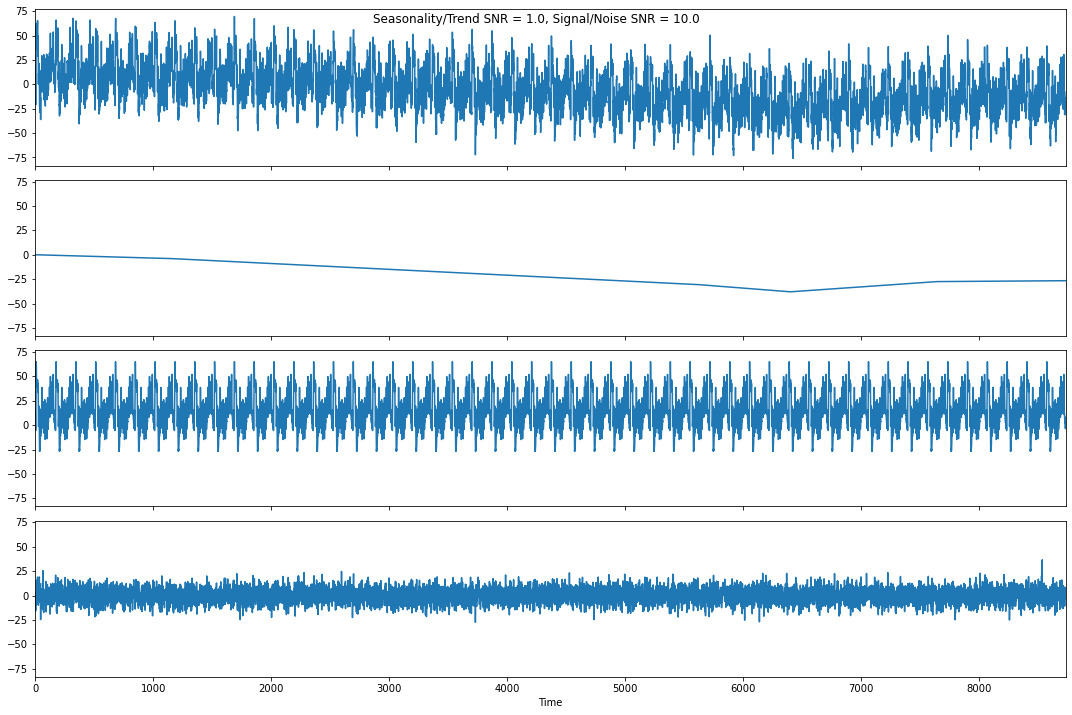

In [56]:
seasonality_type = "sinusoid"
x_t, t_t, s_t, n_t = generate_ts(T=T, seasons=seasons, seasonality_type=seasonality_type, 
                                 seasonality_snr=seasonality_snr, noise_snr=noise_snr)

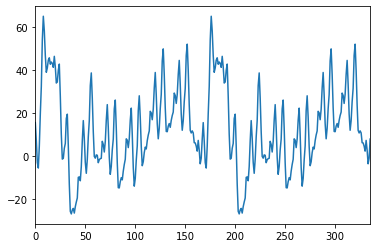

In [57]:
pd.Series(s_t[:np.prod(seasons)*2]).plot();

### Nonnegative CP

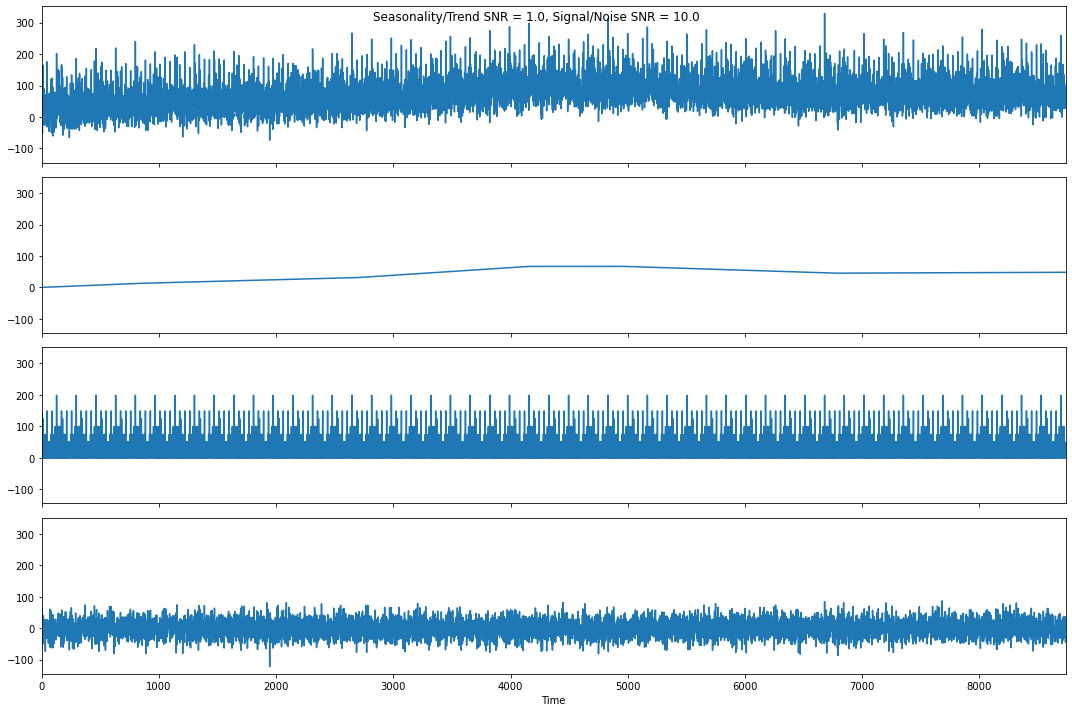

In [58]:
seasonality_type = "nonnegative_cp"
x_t, t_t, s_t, n_t = generate_ts(T=T, seasons=seasons, seasonality_type=seasonality_type, 
                                 seasonality_snr=seasonality_snr, noise_snr=noise_snr)

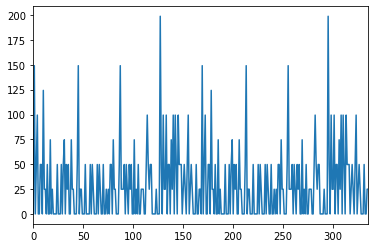

In [59]:
pd.Series(s_t[:np.prod(seasons)*2]).plot();

### CP

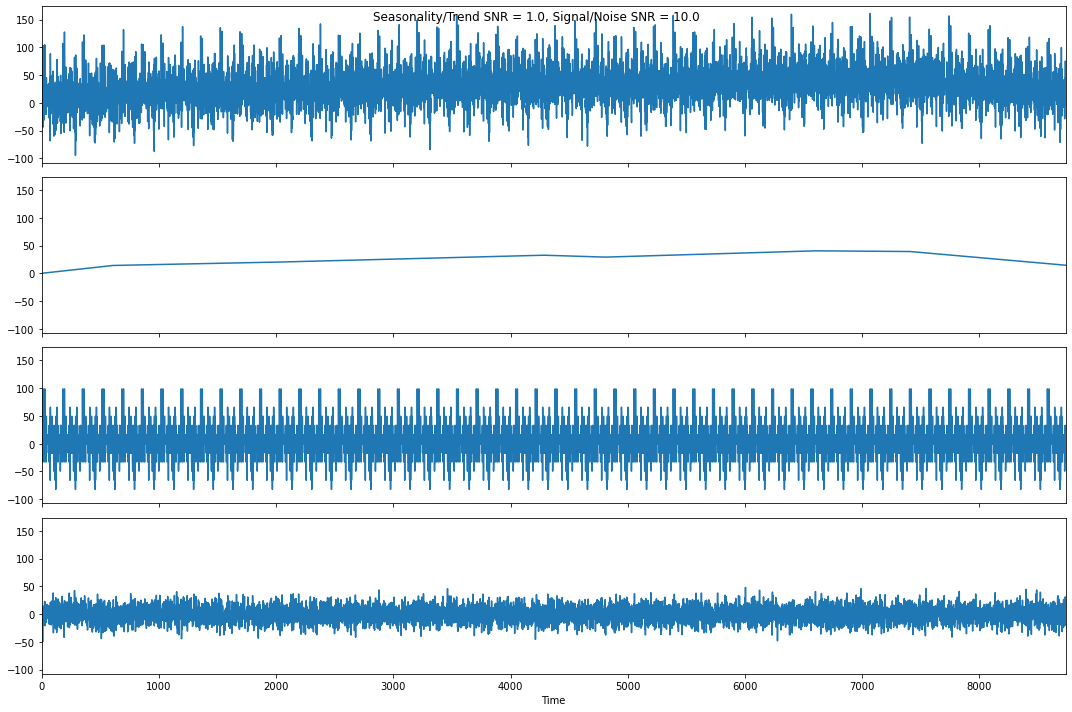

In [60]:
seasonality_type = "cp"
x_t, t_t, s_t, n_t = generate_ts(T=T, seasons=seasons, seasonality_type=seasonality_type, 
                                 seasonality_snr=seasonality_snr, noise_snr=noise_snr)

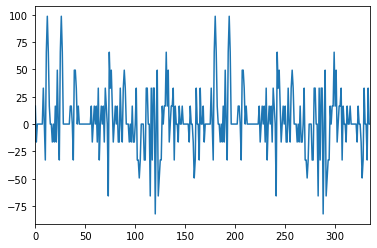

In [61]:
pd.Series(s_t[:np.prod(seasons)*2]).plot();

## Examples: More seasonality

In [62]:
seasons = [60, 24, 7]
T = np.prod(seasons)*4
seasonality_snr = 1.
noise_snr = 10.
seasonality_type = "cp"

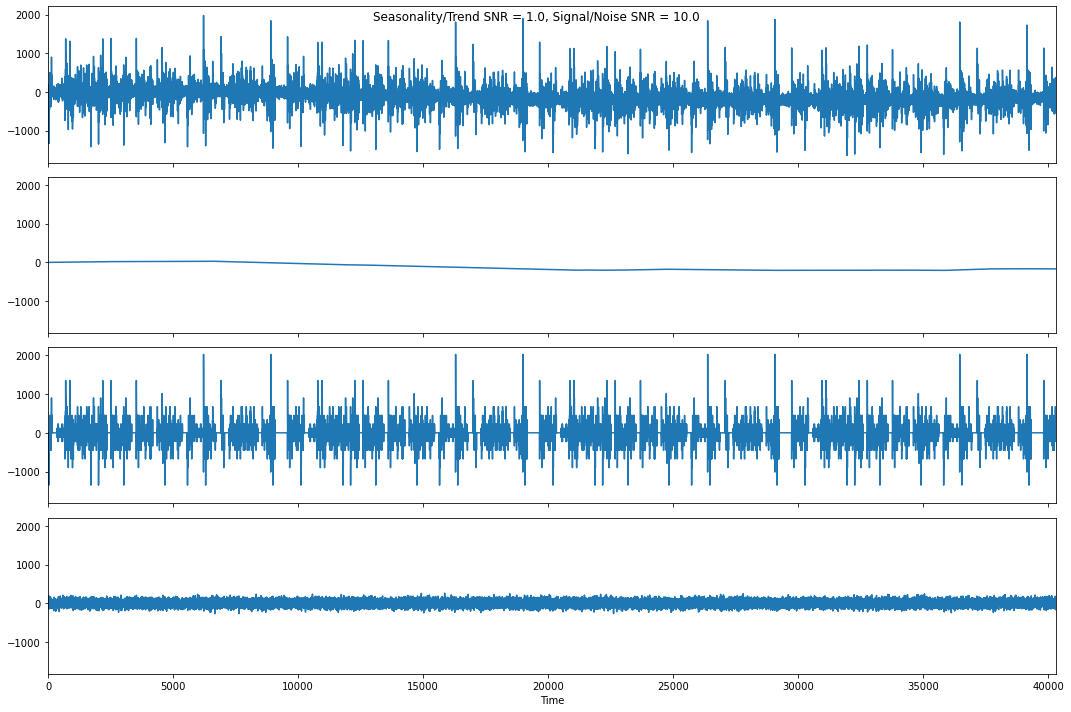

In [63]:
x_t, t_t, s_t, n_t = generate_ts(T=T, seasons=seasons, seasonality_type=seasonality_type, 
                                 seasonality_snr=seasonality_snr, noise_snr=noise_snr)

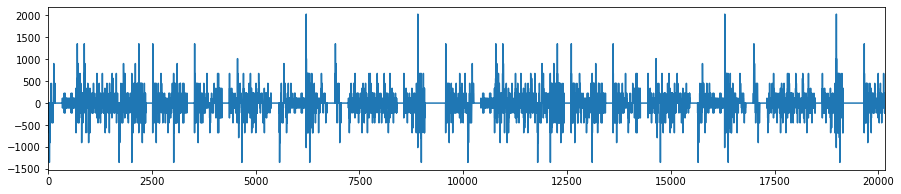

In [66]:
pd.Series(s_t[:np.prod(seasons)*2]).plot(figsize=(15,3));